**1. Imports and Logging Setup**

In this step, I import the core libraries required for the pipeline including networking, data handling, visualization, and database management.
I also configure logging so that every major action in the notebook prints a readable status message, improving traceability and debugging.

In [1]:
import requests
import pandas as pd
import sqlite3
import time
import matplotlib.pyplot as plt
import logging

BASE_URL = "https://api.opendota.com/api"

logging.basicConfig(level=logging.INFO)

**2. Fetching Raw Match Data from the API**

Here, I define and execute a function that retrieves recent professional Dota 2 match records from the OpenDota API.
I limit responses to avoid unnecessary load and return a preview of the dataset so I can inspect structure and sample values.

In [2]:
def fetch_pro_matches(limit=100):
  logging.info("Fetching data from OpenDota API...")
  url = f"{BASE_URL}/proMatches"
  response = requests.get(url)
  response.raise_for_status()
  data = response.json()
  return data[:limit]

raw_matches = fetch_pro_matches(limit=200)
len(raw_matches), raw_matches[:2]


(100,
 [{'match_id': 8599544026,
   'duration': 1906,
   'start_time': 1765409067,
   'radiant_team_id': 8970060,
   'radiant_name': 'Moonwalkers',
   'dire_team_id': 9048057,
   'dire_name': 'Vitality Warriors',
   'leagueid': 16110,
   'league_name': 'Dota 2 Space League',
   'series_id': 1045426,
   'series_type': 1,
   'radiant_score': 36,
   'dire_score': 32,
   'radiant_win': True,
   'version': None},
  {'match_id': 8599520136,
   'duration': 1720,
   'start_time': 1765406793,
   'radiant_team_id': 9048057,
   'radiant_name': 'Vitality Warriors',
   'dire_team_id': 8970060,
   'dire_name': 'Moonwalkers',
   'leagueid': 16110,
   'league_name': 'Dota 2 Space League',
   'series_id': 1045426,
   'series_type': 1,
   'radiant_score': 35,
   'dire_score': 21,
   'radiant_win': True,
   'version': 22}])

**3. Converting API Output into a DataFrame**

In this section, I load the raw JSON data into a pandas DataFrame.
This allows cleaner inspection, easier manipulation, and access to familiar data-analysis workflows.


In [3]:
matches_df = pd.DataFrame(raw_matches)

logging.info(f"Loaded {matches_df.shape[0]} records into DataFrame.")

print(matches_df.shape)
display(matches_df.head())

matches_df.columns.tolist()


(100, 15)


,match_id,duration,start_time,radiant_team_id,radiant_name,dire_team_id,dire_name,leagueid,league_name,series_id,series_type,radiant_score,dire_score,radiant_win,version
0,8599544026,1906,1765409067,8970060.0,Moonwalkers,9048057.0,Vitality Warriors,16110,Dota 2 Space League,1045426,1,36,32,True,NaN
1,8599520136,1720,1765406793,9048057.0,Vitality Warriors,8970060.0,Moonwalkers,16110,Dota 2 Space League,1045426,1,35,21,True,22.0
2,8599488300,1639,1765404093,9025669.0,CrimsonSky,8849990.0,REAL ECLIPSE,16110,Dota 2 Space League,1045412,1,21,42,False,22.0
3,8599459231,1562,1765401906,8849990.0,REAL ECLIPSE,9025669.0,CrimsonSky,16110,Dota 2 Space League,1045412,1,33,18,True,22.0
4,8599419357,1810,1765399286,8879077.0,Titan Strikers,8957156.0,Silent killer,16110,Dota 2 Space League,1045388,1,22,40,False,22.0


['match_id',
 'duration',
 'start_time',
 'radiant_team_id',
 'radiant_name',
 'dire_team_id',
 'dire_name',
 'leagueid',
 'league_name',
 'series_id',
 'series_type',
 'radiant_score',
 'dire_score',
 'radiant_win',
 'version']

**4. Cleaning, Enriching, and Structuring the Match Data**

Here, I implement a transformation function that selects important fields, converts timestamps into readable formats, calculates additional features (such as match duration in minutes), and labels which team won.
This prepares the dataset for analysis and storage.

In [4]:
def clean_pro_matches(df: pd.DataFrame) -> pd.DataFrame:
    logging.info("Cleaning raw match data and engineering features...")

    target_cols = ["match_id", "duration", "start_time", "radiant_win", "radiant_name", "dire_name", "league_name", "radiant_score", "dire_score"]

    cols = [c for c in target_cols if c in df.columns]
    clean = df[cols].copy()

    if "start_time" in clean.columns:
        clean["start_time"] = pd.to_datetime(clean["start_time"], unit="s")

    if "duration" in clean.columns:
        clean["duration_minutes"] = clean["duration"] / 60

    if "radiant_win" in clean.columns:
        clean["winner_side"] = clean["radiant_win"].map({True: "Radiant", False: "Dire"})

    if "start_time" in clean.columns:
        clean = clean.sort_values("start_time", ascending=False)

    return clean

clean_matches_df = clean_pro_matches(matches_df)
clean_matches_df.head()


,match_id,duration,start_time,radiant_win,radiant_name,dire_name,league_name,radiant_score,dire_score,duration_minutes,winner_side
0,8599544026,1906,2025-12-10 23:24:27,True,Moonwalkers,Vitality Warriors,Dota 2 Space League,36,32,31.766667,Radiant
1,8599520136,1720,2025-12-10 22:46:33,True,Vitality Warriors,Moonwalkers,Dota 2 Space League,35,21,28.666667,Radiant
2,8599488300,1639,2025-12-10 22:01:33,False,CrimsonSky,REAL ECLIPSE,Dota 2 Space League,21,42,27.316667,Dire
3,8599459231,1562,2025-12-10 21:25:06,True,REAL ECLIPSE,CrimsonSky,Dota 2 Space League,33,18,26.033333,Radiant
4,8599419357,1810,2025-12-10 20:41:26,False,Titan Strikers,Silent killer,Dota 2 Space League,22,40,30.166667,Dire


**5. Saving the Processed Data into SQLite Storage**

This step persists the cleaned dataset into a SQLite database file.
Saving data ensures that downstream systems — including dashboards, APIs, or machine-learning models — can access the results without rerunning the pipeline.

In [5]:
DB_PATH = "dota_matches.db"

def save_matches_to_db(df: pd.DataFrame, db_path: str = DB_PATH, table_name: str = "matches"):
    logging.info(f"Saving cleaned data into database at {db_path}...")
    conn = sqlite3.connect(db_path)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()
    logging.info(f"Saved {len(df)} rows to table '{table_name}'.")

    print(f"Saved {len(df)} rows to {db_path} (table '{table_name}')")

save_matches_to_db(clean_matches_df)



Saved 100 rows to dota_matches.db (table 'matches')


**6. Validating Stored Records**

To confirm that database storage succeeded, I run a simple SQL query to fetch a few example rows.
This verifies that data loading worked correctly.

In [6]:
with sqlite3.connect(DB_PATH) as conn:
    check_df = pd.read_sql_query("SELECT * FROM matches LIMIT 5;", conn)

check_df


,match_id,duration,start_time,radiant_win,radiant_name,dire_name,league_name,radiant_score,dire_score,duration_minutes,winner_side
0,8599544026,1906,2025-12-10 23:24:27,1,Moonwalkers,Vitality Warriors,Dota 2 Space League,36,32,31.766667,Radiant
1,8599520136,1720,2025-12-10 22:46:33,1,Vitality Warriors,Moonwalkers,Dota 2 Space League,35,21,28.666667,Radiant
2,8599488300,1639,2025-12-10 22:01:33,0,CrimsonSky,REAL ECLIPSE,Dota 2 Space League,21,42,27.316667,Dire
3,8599459231,1562,2025-12-10 21:25:06,1,REAL ECLIPSE,CrimsonSky,Dota 2 Space League,33,18,26.033333,Radiant
4,8599419357,1810,2025-12-10 20:41:26,0,Titan Strikers,Silent killer,Dota 2 Space League,22,40,30.166667,Dire


**7. Computing Initial Summary Statistics**

Here, I calculate basic insights:total match count, average duration, win rate split between Radiant and Dire teams.
This validates the dataset and demonstrates its potential analytical value.

In [7]:
print("Total number of Matches:", len(clean_matches_df))

if "duration_minutes" in clean_matches_df.columns:
  avg_duration = round(clean_matches_df["duration_minutes"].mean(), 2)
  print("Average match duration (minutes):", avg_duration)

if "winner_side" in clean_matches_df.columns:
  print("\nWinrate by side:")
  print(clean_matches_df["winner_side"].value_counts(normalize=True).rename("proportion"))

Total number of Matches: 100
Average match duration (minutes): 33.41

Winrate by side:
winner_side
Radiant    0.58
Dire       0.42
Name: proportion, dtype: float64


**8. Visualizing Match Duration Distribution**

In this section, I generate a histogram illustrating match durations in minutes.
Visual exploration helps identify common game lengths and potential anomalies.


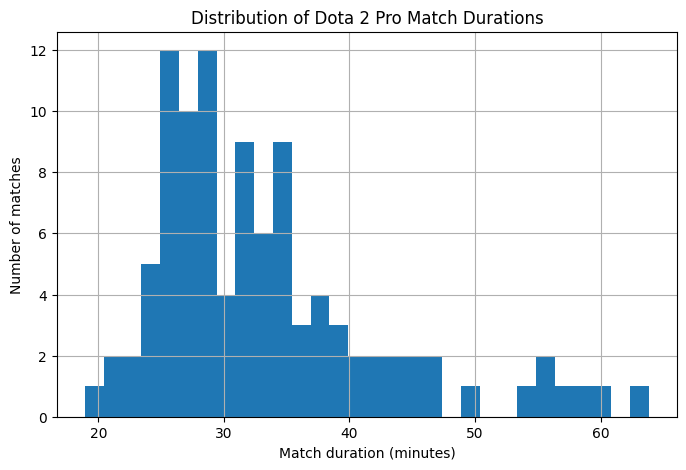

In [8]:
if "duration_minutes" in clean_matches_df.columns:
  plt.figure(figsize=(8, 5))
  clean_matches_df["duration_minutes"].hist(bins=30)
  plt.xlabel("Match duration (minutes)")
  plt.ylabel("Number of matches")
  plt.title("Distribution of Dota 2 Pro Match Durations")
  plt.show()
else:
  print("Duration_minutes column not found.")

**9. Wrapping Pipeline Operations into a Reusable Function**

To improve modularity, I encapsulate the full pipeline (fetch → clean → store → return) into a single callable function.
This enables reuse, scheduling, automation, and integration into applications.

In [9]:
def run_pro_matches_pipeline(limit=200, db_path="dota_matches.db"):
    logging.info(f"Fetching up to {limit} pro matches from OpenDota...")
    raw = fetch_pro_matches(limit=limit)
    df = pd.DataFrame(raw)
    logging.info(f"Retrieved {len(df)} raw matches")

    logging.info("Cleaning and transforming data...")
    clean = clean_pro_matches(df)
    logging.info(f"Cleaned {len(clean)} matches")

    logging.info("Saving to database...")
    save_matches_to_db(clean, db_path=db_path)
    logging.info("Pipeline run complete!")

    return clean

clean_matches_df = run_pro_matches_pipeline(limit=200)
clean_matches_df.head()


Saved 100 rows to dota_matches.db (table 'matches')


,match_id,duration,start_time,radiant_win,radiant_name,dire_name,league_name,radiant_score,dire_score,duration_minutes,winner_side
0,8599544026,1906,2025-12-10 23:24:27,True,Moonwalkers,Vitality Warriors,Dota 2 Space League,36,32,31.766667,Radiant
1,8599520136,1720,2025-12-10 22:46:33,True,Vitality Warriors,Moonwalkers,Dota 2 Space League,35,21,28.666667,Radiant
2,8599488300,1639,2025-12-10 22:01:33,False,CrimsonSky,REAL ECLIPSE,Dota 2 Space League,21,42,27.316667,Dire
3,8599459231,1562,2025-12-10 21:25:06,True,REAL ECLIPSE,CrimsonSky,Dota 2 Space League,33,18,26.033333,Radiant
4,8599419357,1810,2025-12-10 20:41:26,False,Titan Strikers,Silent killer,Dota 2 Space League,22,40,30.166667,Dire


**10. Unit Test for the Transformation Logic**

Here, I build a small unit test to verify that the cleaning function behaves correctly —
checking column presence, derived features, and value correctness.
Testing improves reliability and academic rigor.

In [10]:
def test_clean_pro_matches():
    sample = [
        {
            "match_id": 123,
            "duration": 1800,
            "start_time": 1700000000,
            "radiant_win": True,
            "radiant_name": "Team Radiant",
            "dire_name": "Team Dire",
            "league_name": "Test League",
            "radiant_score": 30,
            "dire_score": 20,
        }
    ]

    df_sample = pd.DataFrame(sample)
    cleaned = clean_pro_matches(df_sample)

    assert len(cleaned) == 1
    assert "match_id" in cleaned.columns
    assert "duration_minutes" in cleaned.columns
    assert "winner_side" in cleaned.columns
    assert cleaned["duration_minutes"].iloc[0] == 1800 / 60
    assert cleaned["winner_side"].iloc[0] == "Radiant"

    print("test_clean_pro_matches passed!")

test_clean_pro_matches()


test_clean_pro_matches passed!


**11. Integration Test for the Full Pipeline**

In this stage, I run an integration test to confirm that all pipeline components work together.
The test checks data retrieval, transformation, storage, and database access.
This mimics real-world validation.

In [11]:
def test_run_pro_matches_pipeline_small():
    test_db = "test_dota_matches.db"

    clean = run_pro_matches_pipeline(limit=20, db_path=test_db)

    assert not clean.empty
    assert "match_id" in clean.columns

    with sqlite3.connect(test_db) as conn:
      df_db = pd.read_sql_query("SELECT * FROM matches LIMIT 5;", conn)

    assert not df_db.empty
    print("test_run_pro_matches_pipeline_small passed!")

test_run_pro_matches_pipeline_small()


Saved 20 rows to test_dota_matches.db (table 'matches')
test_run_pro_matches_pipeline_small passed!


**12. Converting Pipeline Logic into Object-Oriented Structure**

This section applies object-oriented programming principles.
I create modular classes for API access, transformation, database storage, and orchestration.
This reflects scalable software design and clean architecture techniques.

In [12]:
class OpenDotaClient:
    """API client for retrieving data from OpenDota"""

    def __init__(self, base_url="https://api.opendota.com/api"):
        self.base_url = base_url

    def fetch_pro_matches(self, limit=100):
        """Fetch recent professional matches"""
        url = f"{self.base_url}/proMatches"
        logging.info("Fetching data from OpenDota...")
        response = requests.get(url)
        response.raise_for_status()
        return response.json()[:limit]


class MatchTransformer:
    """Handles dataset transformation logic"""

    def clean(self, df: pd.DataFrame) -> pd.DataFrame:
        logging.info("Cleaning match data...")

        target_cols = [
            "match_id", "duration", "start_time",
            "radiant_win", "radiant_name", "dire_name",
            "league_name", "radiant_score", "dire_score"
        ]

        cols = [c for c in target_cols if c in df.columns]
        clean = df[cols].copy()

        if "start_time" in clean.columns:
            clean["start_time"] = pd.to_datetime(clean["start_time"], unit="s")

        if "duration" in clean.columns:
            clean["duration_minutes"] = clean["duration"] / 60

        if "radiant_win" in clean.columns:
            clean["winner_side"] = clean["radiant_win"].map({True: "Radiant", False: "Dire"})

        if "start_time" in clean.columns:
            clean = clean.sort_values("start_time", ascending=False)

        return clean


class DatabaseManager:
    """Handles SQLite saving and retrieval"""

    def __init__(self, db_path="dota_matches.db"):
        self.db_path = db_path

    def save(self, df: pd.DataFrame, table_name="matches"):
        logging.info(f"Saving {len(df)} records into '{table_name}' table...")
        with sqlite3.connect(self.db_path) as conn:
            df.to_sql(table_name, conn, if_exists="replace", index=False)
        logging.info("Save complete.")

class MatchPipeline:
    """Coordinates API fetch, transformation, and DB saving."""

    def __init__(self, api_client, transformer, database):
        self.api_client = api_client
        self.transformer = transformer
        self.database = database

    def run(self, limit=200):
        logging.info("Running object-oriented pipeline...")

        raw_data = self.api_client.fetch_pro_matches(limit=limit)
        df = pd.DataFrame(raw_data)

        clean_df = self.transformer.clean(df)

        self.database.save(clean_df)

        return clean_df



**13. Running the OOP-Based Pipeline**

Next, I instantiate the pipeline classes and execute the object-oriented workflow.
This validates that abstraction works and produces identical cleaned data.

In [13]:
client = OpenDotaClient()
transformer = MatchTransformer()
db = DatabaseManager("dota_matches.db")

pipeline = MatchPipeline(client, transformer, db)

clean_df_oop = pipeline.run(limit=200)

clean_df_oop.head()


,match_id,duration,start_time,radiant_win,radiant_name,dire_name,league_name,radiant_score,dire_score,duration_minutes,winner_side
0,8599544026,1906,2025-12-10 23:24:27,True,Moonwalkers,Vitality Warriors,Dota 2 Space League,36,32,31.766667,Radiant
1,8599520136,1720,2025-12-10 22:46:33,True,Vitality Warriors,Moonwalkers,Dota 2 Space League,35,21,28.666667,Radiant
2,8599488300,1639,2025-12-10 22:01:33,False,CrimsonSky,REAL ECLIPSE,Dota 2 Space League,21,42,27.316667,Dire
3,8599459231,1562,2025-12-10 21:25:06,True,REAL ECLIPSE,CrimsonSky,Dota 2 Space League,33,18,26.033333,Radiant
4,8599419357,1810,2025-12-10 20:41:26,False,Titan Strikers,Silent killer,Dota 2 Space League,22,40,30.166667,Dire


**14. Testing the OOP Pipeline**

Here, I test the class-based pipeline on a smaller dataset.
This ensures that modular components interact correctly, the database is updated, and output integrity is preserved.

In [14]:
def test_oop_pipeline_small():
    test_db = "test_oop_dota_matches.db"

    oop_db = DatabaseManager(test_db)
    oop_pipeline = MatchPipeline(OpenDotaClient(), MatchTransformer(), oop_db)

    clean = oop_pipeline.run(limit=20)

    assert not clean.empty
    assert "match_id" in clean.columns

    with sqlite3.connect(test_db) as conn:
        df_db = pd.read_sql_query("SELECT * FROM matches LIMIT 5;", conn)

    assert not df_db.empty

    print("test_oop_pipeline_small passed!")

test_oop_pipeline_small()


test_oop_pipeline_small passed!


**15. Flask API Layer for Serving Data**

In this section, I introduce a Flask microservice that exposes pipeline output via REST endpoints.
This demonstrates how applications or dashboards can retrieve match data or trigger the pipeline remotely.

In [15]:
from flask import Flask, jsonify
import sqlite3
import pandas as pd

# Initialize Flask app
app = Flask(__name__)
DB_PATH = "dota_matches.db"

def fetch_matches_from_db(limit=50):
    """Utility to read matches from SQLite database"""
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql_query(f"SELECT * FROM matches LIMIT {limit};", conn)
    return df

@app.route("/")
def home():
    return jsonify({"message": "Dota 2 Match Pipeline API running"})

@app.route("/matches", methods=["GET"])
def get_matches():
    """Return sample match records from DB"""
    df = fetch_matches_from_db()
    return jsonify(df.to_dict(orient="records"))

@app.route("/run_pipeline", methods=["POST"])
def run_pipeline_api():
    """Trigger pipeline and return row count"""
    pipeline = MatchPipeline(OpenDotaClient(), MatchTransformer(), DatabaseManager(DB_PATH))
    clean_df = pipeline.run(limit=150)

    return jsonify({"status": "pipeline executed", "rows_saved": len(clean_df)})

# Only run if executed as script, not inside notebook
if __name__ == "__main__":
    app.run(host="0.0.0.0", port=9090, debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:9090
 * Running on http://172.28.0.12:9090
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


**16. FastAPI Layer for High-Performance API Serving**

Here, I develop a FastAPI version of the service.
FastAPI provides modern, asynchronous support, better documentation generation, and production-style interfacing.

In [16]:
from fastapi import FastAPI
import sqlite3
import pandas as pd

app_fast = FastAPI(title="Dota 2 Match Pipeline API")

DB_PATH = "dota_matches.db"

def load_matches(limit=50):
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql_query(f"SELECT * FROM matches LIMIT {limit}", conn)
    return df

@app_fast.get("/")
def root():
    return {"message": "FastAPI service running"}

@app_fast.get("/matches")
def get_matches(limit: int = 50):
    df = load_matches(limit)
    return df.to_dict(orient="records")

@app_fast.post("/run")
def run_pipeline_endpoint(limit: int = 100):
    client = OpenDotaClient()
    transformer = MatchTransformer()
    db = DatabaseManager(DB_PATH)

    pipeline = MatchPipeline(client, transformer, db)
    clean = pipeline.run(limit=limit)

    return {"status": "pipeline executed", "rows_saved": len(clean)}


**17. Streamlit Interactive Dashboard**

This section builds a Streamlit interface that loads match data from SQLite and displays it interactively.
It provides a visual front end useful for demonstrations and analytics use cases.

In [17]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import sqlite3

DB_PATH = "dota_matches.db"

def load_matches(limit=200):
    with sqlite3.connect(DB_PATH) as conn:
        return pd.read_sql_query(f"SELECT * FROM matches LIMIT {limit}", conn)

st.title("Dota 2 Pro Match Dashboard")

data = load_matches()

st.subheader("Match Records")
st.dataframe(data)

st.subheader("Winrate Summary")
if "winner_side" in data.columns:
    st.bar_chart(data["winner_side"].value_counts())


Writing streamlit_app.py


**18. Deployment Instructions for GitHub + GCP**

Finally, I include deployment command references for pushing the project to GitHub and running it on a Google Cloud VM.
This makes the pipeline executable outside Colab and demonstrates real-world hosting readiness.

In [18]:
print("""
# Example Deployment Commands (GCP VM)

sudo apt update && sudo apt install python3-pip -y

git clone https://github.com/USERNAME/REPO.git
cd REPO

pip install -r requirements.txt

# Run Flask
python3 app.py

# Run FastAPI
uvicorn fast_service:app_fast --host 0.0.0.0 --port 9090

# Run Streamlit
streamlit run streamlit_app.py
""")



# Example Deployment Commands (GCP VM)

sudo apt update && sudo apt install python3-pip -y

git clone https://github.com/USERNAME/REPO.git
cd REPO

pip install -r requirements.txt

# Run Flask
python3 app.py

# Run FastAPI
uvicorn fast_service:app_fast --host 0.0.0.0 --port 9090

# Run Streamlit
streamlit run streamlit_app.py

